# Deadlines

In [1]:
from configs.config import get_path
import src.utils.converter as convert
import src.utils.presenter as show
import src.utils.checker as check
import pandas as pd

import src.utils.gen_interarrival as gen_interarrival
import src.models.heuristics.fcfs as solver

In [2]:
basic_data_path = get_path("data", "basic")

df_instance = pd.read_csv(basic_data_path / "00_instance.csv")
df_instance

,Job,Operation,Machine,Processing Time
0,job 0,0,M0,29
1,job 0,1,M1,78
2,job 0,2,M2,9
3,job 0,3,M3,36
4,job 0,4,M4,49
...,...,...,...,...
95,job 9,5,M9,76
96,job 9,6,M5,47
97,job 9,7,M3,52
98,job 9,8,M4,90


### a) Ankunftszeiten

In [3]:
mean_interarrival_time = gen_interarrival.calculate_mean_interarrival_time(df_instance)
mean_interarrival_time

70.11

In [4]:
df_jobs_arrivals = gen_interarrival.generate_arrivals(df_instance, mean_interarrival_time=mean_interarrival_time)
df_jobs_arrivals

,Job,Arrival
0,job 0,0.00
1,job 1,84.93
2,job 2,106.18
3,job 3,148.31
4,job 4,185.08
5,job 5,251.37
6,job 6,312.71
7,job 7,329.63
8,job 8,344.30
9,job 9,429.20


### b) Schedule

In [5]:
df_fcfs = solver.schedule_fcfs_with_arrivals(df_instance, df_jobs_arrivals)
df_fcfs

,Job,Operation,Arrival,Machine,Start,Processing Time,End
0,job 0,0,0.0,M0,0.0,29,29.0
1,job 0,1,0.0,M1,29.0,78,107.0
2,job 0,2,0.0,M2,107.0,9,116.0
3,job 0,3,0.0,M3,116.0,36,152.0
4,job 0,4,0.0,M4,152.0,49,201.0
...,...,...,...,...,...,...,...
95,job 9,5,429.2,M9,1040.0,76,1116.0
96,job 9,6,429.2,M5,1116.0,47,1163.0
97,job 9,7,429.2,M3,1173.0,52,1225.0
98,job 9,8,429.2,M4,1225.0,90,1315.0


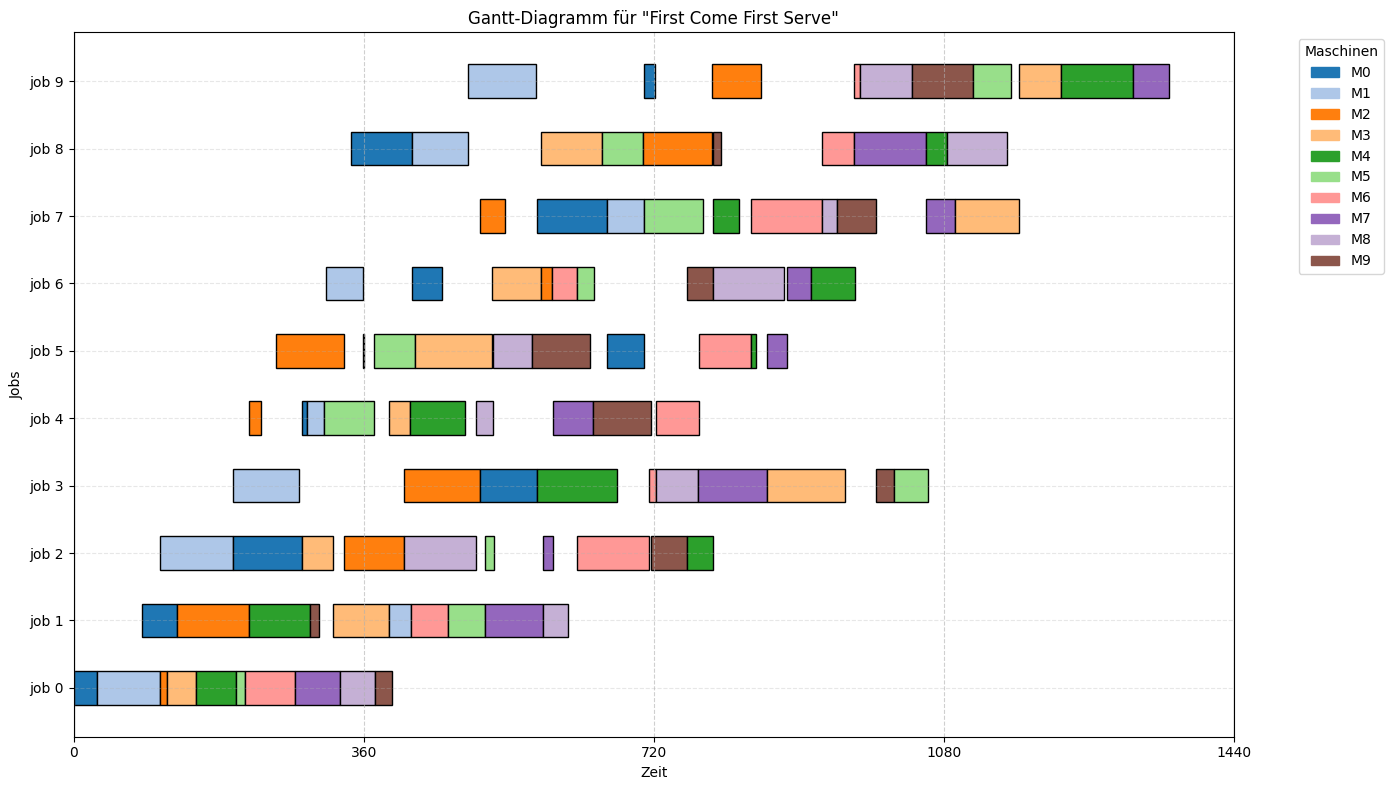

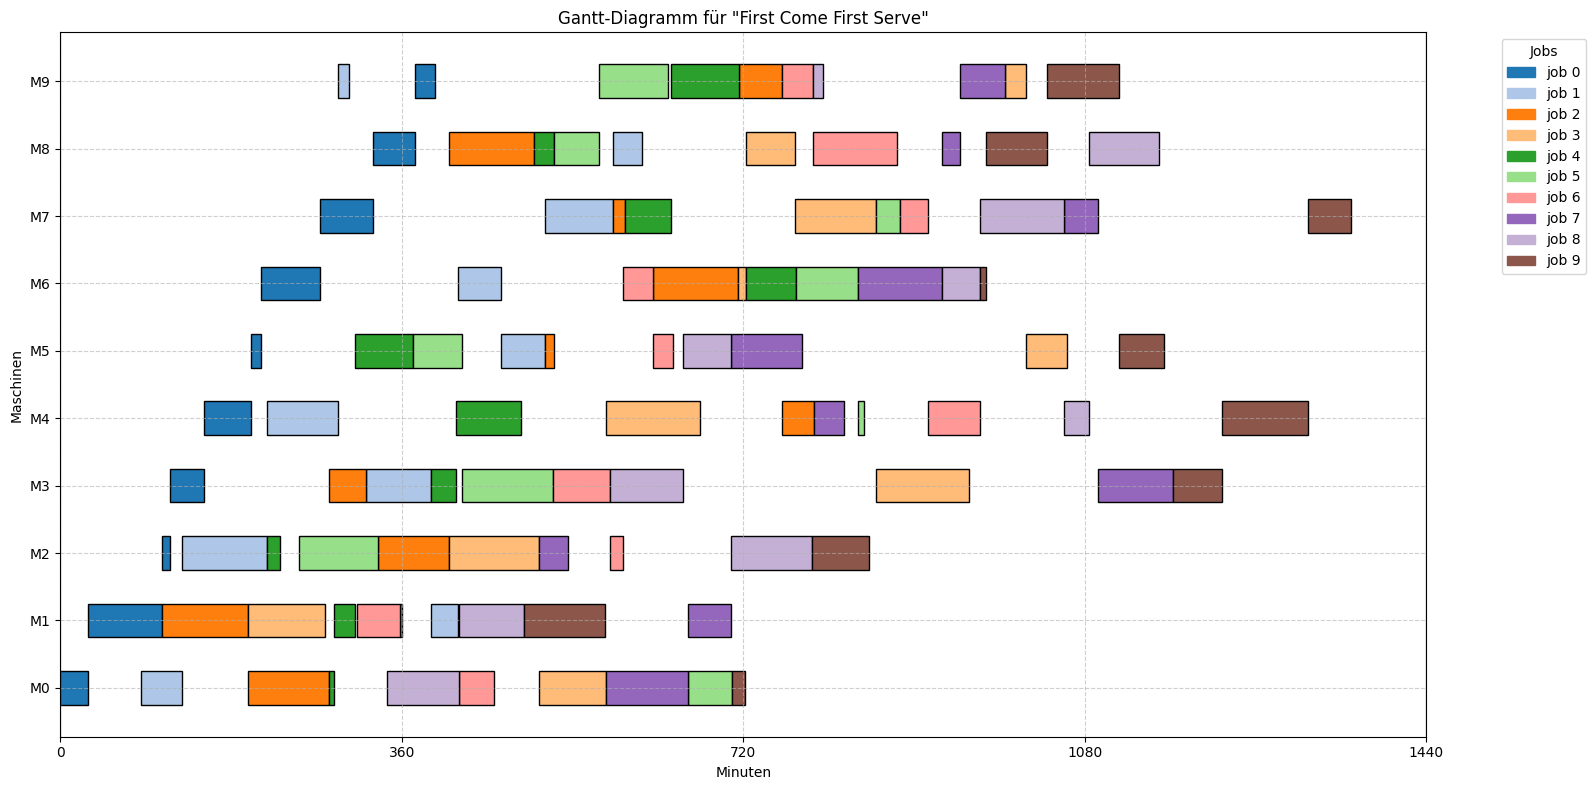

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.



True

In [6]:
category = "First Come First Serve"

show.plot_gantt_jobs(df_fcfs, 'Gantt-Diagramm für "{}"'.format(category), duration_column= "Processing Time")
show.plot_gantt_machines(df_fcfs, 'Gantt-Diagramm für "{}"'.format(category), duration_column= "Processing Time")

check.check_constraints(df_fcfs)

## Deadlines

$$
{d_{j}=a_{j}+k\,p_{j}}
$$  

$$
S(k)=\frac{1}{n}\sum_{j=1}^{n}\mathbf{1}\!\bigl[C_{j}(k)\le d_{j}(k)\bigr]
$$  

$$
S(k)\;\ge\;S_{\text{target}}
$$  

---

* **$a_{j}$** – Ankunftszeit (Release-Date) von Job $j$  
* **$p_{j}$** – *Processing time* des Jobs (aus dem Job Shop Scheduling-Problem) 

  $$p_{j}=\sum_{(m,d)\in j} d$$  

  Summe aller Operationsdauern $d$ von Job $j$ über sämtliche Maschinen $m$.  
* **$k$** – Due-Date-Faktor, den die Binärsuche einstellt  
* **$d_{j}$** – zugewiesene Deadline für Job $j$  
* **$C_{j}(k)$** – Fertigstellzeit von Job $j$ im geplanten Schedule bei Faktor $k$  
* **$\mathbf{1}[\;\cdot\;]$** – Indikatorfunktion (1, wenn Aussage wahr; sonst 0)  
* **$S(k)$** – gemessener Service-Level (Anteil pünktlicher Jobs) bei Faktor $k$  
* **$S_{\text{target}}$** – gewünschter Mindest-Service-Level (z. B. $0{,}95$ - mindestens $95$% aller **Jobs** sollen ihre **Deadline** einhalten)  


In [7]:
def find_k(df_jssp: pd.DataFrame,
           arrivals: pd.DataFrame,
           schedule_func,
           target_service: float = 0.95,
           buffer_factor: float = 1.75):
    """
    Sucht per Binärsuche den Faktor k, sodass der gegebene schedule_func
    auf Basis df_jssp und arrivals einen Service-Level ≥ target_service erreicht.

    Rückgabe:
    - k: gefundener Skalierungsfaktor
    - df_deadlines: DataFrame mit Spalten ['Job','Deadline']
    """
    # Base schedule (ohne Deadlines)
    df_sched = schedule_func(df_jssp, arrivals)

    lo, hi = 0.5, 10.0
    for _ in range(30):
        k = (lo + hi) / 2
        # Deadlines als Dict für schnellen Map-Vergleich
        df_dead_tmp = _calc_due_dates(df_jssp, arrivals, k, buffer_factor=1.0)
        d_tmp = df_dead_tmp.set_index('Job')['Deadline'].to_dict()
        # Anteil pünktlicher Jobs
        on_time = (df_sched['End'] <= df_sched['Job'].map(d_tmp)).mean()
        if on_time >= target_service:
            hi = k
        else:
            lo = k

    # Finales Deadline-DF mit Puffer
    df_deadlines = _calc_due_dates(df_jssp, arrivals, k, buffer_factor)

    return k, df_deadlines


def _calc_due_dates(df_jssp: pd.DataFrame,
                    arrivals: pd.DataFrame,
                    k: float,
                    buffer_factor: float = 1.0) -> pd.DataFrame:
    """
    Berechnet Deadlines:
      d_j = a_j + (k * p_j) * buffer_factor

    Rückgabe:
    - DataFrame mit ['Job','Deadline']
    """
    # p_j: Gesamtprozesszeit
    p_tot = df_jssp.groupby('Job')['Processing Time'].sum().rename('p_tot')
    # a_j: Ankunftszeit
    a = arrivals.set_index('Job')['Arrival'].rename('a_j')
    df = pd.concat([p_tot, a], axis=1).reset_index()
    df['Deadline'] = df['a_j'] + (k * df['p_tot']) * buffer_factor
    return df[['Job', 'Deadline']]

In [8]:
k_opt, df_deadlines = find_k(df_instance, df_jobs_arrivals, solver.schedule_fcfs_with_arrivals, target_service=0.95)
print(f"Gefundener Due-Date-Faktor k = {k_opt:.4f}")

Gefundener Due-Date-Faktor k = 1.4737


In [9]:
df_jobs = df_jobs_arrivals.merge(df_deadlines, on='Job', how='left').sort_values('Arrival').reset_index(drop=True)
df_jobs

,Job,Arrival,Deadline
0,job 0,0.00,1018.697689
1,job 1,84.93,1400.210561
2,job 2,106.18,1571.041488
3,job 3,148.31,1837.542877
4,job 4,185.08,1198.619726
5,job 5,251.37,1530.544820
6,job 6,312.71,1385.566301
7,job 7,329.63,1719.701024
8,job 8,344.30,1883.951951
9,job 9,429.20,1821.850006


In [10]:
df_temp= df_fcfs.groupby('Job', as_index=False).agg(End=('End', 'max'))
df_jobs.merge(df_temp, on="Job").sort_values("Arrival")[["Job","Arrival", "End", "Deadline"]]

,Job,Arrival,End,Deadline
0,job 0,0.00,395.0,1018.697689
1,job 1,84.93,613.0,1400.210561
2,job 2,106.18,794.0,1571.041488
3,job 3,148.31,1061.0,1837.542877
4,job 4,185.08,776.0,1198.619726
5,job 5,251.37,885.0,1530.544820
6,job 6,312.71,970.0,1385.566301
7,job 7,329.63,1173.0,1719.701024
8,job 8,344.30,1158.0,1883.951951
9,job 9,429.20,1360.0,1821.850006
